In [1]:
from matplotlib import pyplot,cm
from math import pi
import numpy
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from mpl_toolkits.mplot3d import Axes3D
import numba
from numba import jit

In [5]:
def plot_3D(x,y,u):    
    fig = pyplot.figure(figsize=(11,7), dpi=100)
    ax = fig.gca(projection='3d')
    X,Y = numpy.meshgrid(x,y)
    surf = ax.plot_surface(X,Y,u[:], rstride=1, cstride=1, cmap=cm.viridis,
            linewidth=0, antialiased=False)
    
    ax.set_xlim(0,2*pi)
    ax.set_ylim(0,2*pi)

    ax.set_xlabel('$x$') 
    ax.set_ylabel('$y$')
    ax.set_zlabel('$u$')
    ax.view_init(30,45)

In [3]:
ni=51
nj=51
dx=2*pi/(ni-1)
dy=2*pi/(nj-1)
x=numpy.linspace(-dx/2,2*pi+dx/2,ni+1)
y=numpy.linspace(-dy/2,2*pi+dy/2,nj+1)

X,Y=numpy.meshgrid(x,y)

u0=-numpy.cos(X)*numpy.sin(Y)
v0=numpy.sin(X)*numpy.cos(Y)
p0=numpy.cos(2*X)+numpy.cos(2*Y)
omega0=numpy.zeros((nj+1,ni+1))
for i in range(ni):
    for j in range(nj):
        omega0[j,i]=(v0[j,i+1]-v0[j,i])/dx-(u0[j+1,i]-u0[j,i])/2/dy

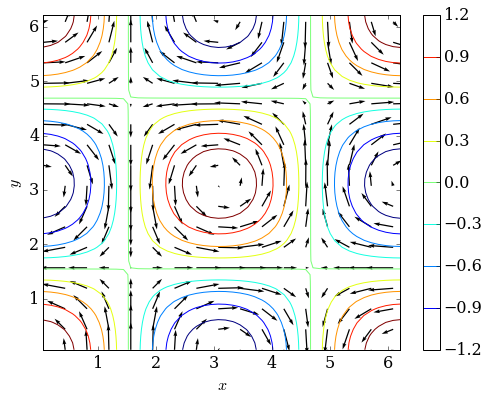

In [7]:
pyplot.figure(figsize=(8,6))
pyplot.contour(X[1:-1,1:-1],Y[1:-1,1:-1],omega0[1:-1,1:-1],10)
pyplot.colorbar()
pyplot.quiver(X[1:-1:3,1:-1:3],Y[1:-1:3,1:-1:3],u0[1:-1:3,1:-1:3],v0[1:-1:3,1:-1:3],scale=13)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')

In [8]:
@jit
def Fc1(u,v,i,j,dx,dy):
    F=-((u[j,i]+u[j,i+1])**2-(u[j,i]+u[j,i-1])**2)/4/dx-\
        ((u[j,i]+u[j+1,i])*(v[j,i+1]+v[j,i])-\
        (u[j,i]+u[j-1,i])*(v[j-1,i+1]+v[j-1,i]))/4/dy
    return F

def Fc2(u,v,i,j,dx,dy):
    F=-((u[j+1,i]+u[j,i])*(v[j,i]+v[j,i+1])-\
        (u[j+1,i-1]+u[j,i-1])*(v[j,i]+v[j,i-1]))/4/dx-\
        ((v[j,i]+v[j+1,i])**2-(v[j,i]+v[j-1,i])**2)/4/dy
    return F

def Fv1(u,v,i,j,dx,dy):
    F=(u[j,i+1]-2*u[j,i]+u[j,i-1])/dx**2+(u[j+1,i]-2*u[j,i]+u[j-1,i])/dy**2
    return F

def Fv2(u,v,i,j,dx,dy):
    F=(v[j,i+1]-2*v[j,i]+v[j,i-1])/dx**2+(v[j+1,i]-2*v[j,i]+v[j-1,i])/dy**2
    return F

def Fp1(p,i,j,dx,dy):
    F=(p[j,i+1]-p[j,i])/dx
    return F

def Fp2(p,i,j,dx,dy):
    F=(p[j+1,i]-p[j,i])/dy
    return F

In [9]:
@jit
def poisson(f,N,omega):
    ni,nj=numpy.shape(f)
    p=numpy.zeros(numpy.shape(f))
    res=numpy.zeros(numpy.shape(f))
    res_max=1e3
    n=0
    while n<N:
        
        for j in range(1,nj):
            for i in range(1,ni):
                p[j,i]=omega/(2*(dx**2+dy**2))*((p[j,i-1]+p[j,i+1])*dy**2+\
                       (p[j-1,i]+p[j+1,i])*dx**2-f[j,i]*dx**2*dy**2)+\
                       (1-omega)*p[j,i]
        p[0,:]=p[1,:]
        p[-1,:]=p[-2,:]
        p[:,0]=p[:,1]
        p[:,-1]=p[:,-2]             
        n+=1
        
    for j in range(1,nj):
        for i in range(1,ni):
            res[j,i]=numpy.abs(f[j,i]-(p[j,i-1]-2*p[j,i]+p[j,i+1])/dx**2-\
                            (p[j-1,i]-2*p[j,i]+p[j+1,i])/dy**2)
            
        res_max=numpy.max(res)
    return p,res_max

In [10]:
dt=0.05
T=10
nt=int(T/dt)
t=0
u=u0.copy()
v=v0.copy()
p=p0.copy()

In [11]:
G1=numpy.zeros((nj+1,ni+1))
G2=numpy.zeros((nj+1,ni+1))
w1=numpy.zeros((nj+1,ni+1))
w2=numpy.zeros((nj+1,ni+1))
f=numpy.zeros((nj+1,ni+1))
for j in range(1,nj):
    for i in range(1,ni):
        G1[j,i]=Fc1(u,v,i,j,dx,dy)+Fv1(u,v,i,j,dx,dy)
        G2[j,i]=Fc2(u,v,i,j,dx,dy)+Fv2(u,v,i,j,dx,dy)
        w1[j,i]=u[j,i]+dt*G1[j,i]/3
        w2[j,i]=v[j,i]+dt*G2[j,i]/3
w1[:,0]=
        f[j,i]=3./dt*((w1[j,i+1]-w1[j,i])/dx+(w2[j+1,i]-w2[j,i])/dy)

In [ ]:
pyplot.figure(figsize=(8,6))
pyplot.contour(X[1:-1,1:-1],Y[1:-1,1:-1],f[1:-1,1:-1],10)
pyplot.colorbar()
pyplot.quiver(X[1:-1:3,1:-1:3],Y[1:-1:3,1:-1:3],w1[1:-1:3,1:-1:3],w1[1:-1:3,1:-1:3],scale=13)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')

In [ ]:
p,res=poisson(f,1000,1.8)
print(res)

In [ ]:
numpy.shape(f)

In [ ]:
plot_3D(x,y,u)

In [ ]:
pyplot.plot()

In [ ]:
p=poisson(f,1e-6,1.8)
for j in range(1,nj):
        for i in range(1,ni):
            u[j,i]=w1[j,i]+dt/3*Fp1(p,i,j,dx,dy)
            v[j,i]=w2[j,i]+dt/3*Fp2(p,i,j,dx,dy)
            
            G1[j,i]=-5./9*G1[j,i]+Fc1(u,v,i,j,dx,dy)+Fv1(u,v,i,j,dx,dy)
            G2[j,i]=-5./9*G2[j,i]+Fc2(u,v,i,j,dx,dy)+Fv2(u,v,i,j,dx,dy)
            w1[j,i]=u[j,i]+dt*15./16*G1[j,i]
            w2[j,i]=v[j,i]+dt*15./16*G2[j,i]
            f[j,i]=12./5/dt*((w1[j,i+1]-w1[j,i-1])/2/dx+(w2[j+1,i]-w2[j-1,i])/2/dy)
    p=poisson(f,1e-6,1.8)
    for j in range(1,nj):
        for i in range(1,ni):
            u[j,i]=w1[j,i]+5./12*dt*Fp1(p,i,j,dx,dy)
            v[j,i]=w2[j,i]+5./12*dt*Fp2(p,i,j,dx,dy)
            
            G1[j,i]=-153./128*G1[j,i]+Fc1(u,v,i,j,dx,dy)+Fv1(u,v,i,j,dx,dy)
            G2[j,i]=-153./128*G2[j,i]+Fc2(u,v,i,j,dx,dy)+Fv2(u,v,i,j,dx,dy)
            w1[j,i]=u[j,i]+8./15*dt*G1[j,i]
            w2[j,i]=v[j,i]+8./15*dt*G2[j,i]
            f[j,i]=4./dt*((w1[j,i+1]-w1[j,i-1])/2/dx+(w2[j+1,i]-w2[j-1,i])/2/dy)
    p=poisson(f,1e-6,1.8)
    for j in range(1,nj):
        for i in range(1,ni):
            u[j,i]=w1[j,i]+dt/4*Fp1(p,i,j,dx,dy)
            v[j,i]=w2[j,i]+dt/4*Fp2(p,i,j,dx,dy)
    t+=1

In [ ]:
ut

In [ ]:
pyplot.figure(figsize=(8,6))
pyplot.contour(X[1:-1,1:-1],Y[1:-1,1:-1],omega[1:-1,1:-1],10)
pyplot.colorbar();
pyplot.quiver(X[1:-1:3,1:-1:3],Y[1:-1:3,1:-1:3],ut[1:-1:3,1:-1:3],vt[1:-1:3,1:-1:3],scale=13)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')

In [ ]:

omega=numpy.zeros((nj+1,ni+1))
for i in range(1,ni-1):
    for j in range(1,nj-1):
        omega[j,i]=(vt[j,i+1]-vt[j,i-1])/2/dx-(ut[j+1,i]-ut[j-1,i])/2/dy

In [ ]:
@jit
def compute(u,v,dx,dy):
    G1=numpy.zeros((nj+1,ni+1))
    G2=numpy.zeros((nj+1,ni+1))
    w1=numpy.zeros((nj+1,ni+1))
    w2=numpy.zeros((nj+1,ni+1))
    f=numpy.zeros((nj+1,ni+1))
    un=u.copy()
    vn=v.copy()
    for j in range(1,nj):
        for i in range(1,ni):
            G1[j,i]=Fc1(un,vn,i,j,dx,dy)+Fv1(un,vn,i,j,dx,dy)
            G2[j,i]=Fc2(un,vn,i,j,dx,dy)+Fv2(un,vn,i,j,dx,dy)
            w1[j,i]=un[j,i]+dt*G1[j,i]/3
            w2[j,i]=vn[j,i]+dt*G2[j,i]/3
            f[j,i]=3./dt*((w1[j,i+1]-w1[j,i-1])/2/dx+(w2[j+1,i]-w2[j-1,i])/2/dy)
    p=poisson(f,1e-6,1.8)
    for j in range(1,nj):
        for i in range(1,ni):
            un[j,i]=w1[j,i]+dt/3*Fp1(p,i,j,dx,dy)
            vn[j,i]=w2[j,i]+dt/3*Fp2(p,i,j,dx,dy)
            
            G1[j,i]=-5./9*G1[j,i]+Fc1(un,vn,i,j,dx,dy)+Fv1(un,vn,i,j,dx,dy)
            G2[j,i]=-5./9*G2[j,i]+Fc2(un,vn,i,j,dx,dy)+Fv2(un,vn,i,j,dx,dy)
            w1[j,i]=un[j,i]+dt*15./16*G1[j,i]
            w2[j,i]=vn[j,i]+dt*15./16*G2[j,i]
            f[j,i]=12./5/dt*((w1[j,i+1]-w1[j,i-1])/2/dx+(w2[j+1,i]-w2[j-1,i])/2/dy)
    p=poisson(f,1e-6,1.8)
    for j in range(1,nj):
        for i in range(1,ni):
            un[j,i]=w1[j,i]+5./12*dt*Fp1(p,i,j,dx,dy)
            vn[j,i]=w2[j,i]+5./12*dt*Fp2(p,i,j,dx,dy)
            
            G1[j,i]=-153./128*G1[j,i]+Fc1(un,vn,i,j,dx,dy)+Fv1(un,vn,i,j,dx,dy)
            G2[j,i]=-153./128*G2[j,i]+Fc2(un,vn,i,j,dx,dy)+Fv2(un,vn,i,j,dx,dy)
            w1[j,i]=un[j,i]+8./15*dt*G1[j,i]
            w2[j,i]=vn[j,i]+8./15*dt*G2[j,i]
            f[j,i]=4./dt*((w1[j,i+1]-w1[j,i-1])/2/dx+(w2[j+1,i]-w2[j-1,i])/2/dy)
    p=poisson(f,1e-6,1.8)
    for j in range(1,nj):
        for i in range(1,ni):
            un[j,i]=w1[j,i]+dt/4*Fp1(p,i,j,dx,dy)
            vn[j,i]=w2[j,i]+dt/4*Fp2(p,i,j,dx,dy)
    
    return un,vn

In [ ]:
omega=numpy.zeros((nj+1,ni+1))
for i in range(1,ni-1):
    for j in range(1,nj-1):
        omega0[j,i]=(v[j,i+1]-v[j,i-1])/2/dx-(u[j+1,i]-u[j-1,i])/2/dy